A place to keep all proper mathematical derivations.

In [70]:
import png
import struct
import zlib
pll = png.Reader(filename=('E:\\Code\\opensource\\games\\Nebula\\icons/obj/closets/bases/crate.dmi'))
pll.preamble()
chks = [x for x in pll.chunks()]
pll.bitdepth
d = zlib.decompressobj()
def iter_deb(rb, byte_blocks):
    a = bytearray()
    # The previous (reconstructed) scanline.
    # None indicates first line of image.
    recon = None
    for some_bytes in byte_blocks:
        a.extend(some_bytes)
        while len(a) >= rb + 1:
            filter_type = a[0]
            scanline = a[1 : rb + 1]
            del a[: rb + 1]
            # if filter_type != 0: print(filter_type)
            # recon = self.undo_filter(filter_type, scanline, recon)
            if filter_type == 0: yield [x for v in scanline for x in [v>>4, v&15]]
    yield []
ba = d.decompress(chks[0][1])
ssss = [x for x in iter_deb(pll.row_bytes, [bytes(x) for x in ba])]
for row in ssss:
    for col in row:
        if col>13:
            print('!')
            break

In [84]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants as C
import sympy as sy

### HE Pipes
#### Replacing numerical integration with analytical

$C_{v,eff} = \min(\dfrac{\nu}{\nu_\eta}, 1)$

$q'_o = q_\odot\overline{F} - \sigma(T - T_{CMB})^4$

$q'_n = q_\odot\overline{F} - \sigma(T^4 - T_{CMB}^4)$

$\Delta T_{1s} = \dfrac{S q' \varepsilon \Delta t}{C_{v,eff}}$ -- effective temperature loss per 1 tile of space.

Now let's reimagine that as $\dfrac{dT}{dx} = A q'(T)$ (where $A = \dfrac{S\varepsilon\Delta t}{C_{v,eff}}$ for simplicity).

While we're at it, let's write $A q_\odot \overline{F} = \delta T_\odot$, $A\sigma = b$.

old version gives us $\dfrac{dT}{dx} = \delta T_\odot - b (T-T_{CMB})^4$; with $y=T-T_{CMB}$, $dy=dT$, $a = \delta T_\odot$, we get to the (1).

NEW version gives us $\dfrac{dT}{dx} = \delta T_\odot + bT_{CMB}^4 - bT^4$; with $y=T$, $a = \delta T_\odot + bT_{CMB}^4$, we get to the (1).


$y' = a - b y^4$; $\dfrac{dy}{a-by^4}=dx$.

This looks troublesome, so let's solve $y'=-by^4$ first and hope that $a$ could be integrated separately.


In [515]:
T, T0, TCMB, qSol, Frel, S, emitt, Cve, sigma_SB = sy.symbols('T T_0 T_{CMB} {q_\\odot} \\overline{F} S \\varepsilon C_{v;eff} \\sigma')

In [516]:
A_ = S * emitt / Cve
b_ = A_ * sigma_SB
dTsol = A_ * qSol * Frel
a_ =  dTsol + b_*TCMB**4

In [517]:
x, y, z, a, b, k, y0, C1 = sy.symbols('x y z a b k y_0 C', real=True, positive=True)

In [98]:
hom_x = sy.integrate(1/(-b*y**4),y) - C1/b/3
hom_y_C = sy.solve(sy.Eq(x, hom_x), y)[0]
hom_C = sy.solve(sy.Eq(y0, hom_y_C.subs({x: 0})), C1)[0]
hom_y = hom_y_C.subs({C1: hom_C})
sy.Eq(y, hom_y)

Eq(y, (3*b*x + y_0**(-3))**(-1/3))

In [55]:
sy.solve(sy.Eq(y, hom_y), x)[0]

(-y**3 + y_0**3)/(3*b*y**3*y_0**3)

In [56]:
hom_x.subs({C:hom_C})

-1/(3*b*y_0**3) + 1/(3*b*y**3)

Now let's look at inhomogeneous formulation:

$y' = a - b y^4 = b (k^4 - y^4)$;

Obviously we should get an equilibrium there at $y=k$.


In [94]:
sy.Eq(k**4, (a_/b_).simplify())

Eq(k**4, T_{CMB}**4 + \overline{F}*{q_\odot}/\sigma)

In [101]:
(0.04 * 200 / C.sigma + 3.15**4)**(1/4)

108.98573021575022

Just as obviously, we can write eq'n as $bdx=dy/(k^4-y^4)$. 

Let's rewrite this in terms of reduced temperature $z = y/k$:

$bk^3dx = dz/(1-z^4)$

Integrating separately, we get

In [112]:
sy.Eq(C1+4*b*k**3*x, sy.integrate(4/(1-z**4),z))

Eq(C + 4*b*k**3*x, -log(z - 1) + log(z + 1) + 2*atan(z))

Let's think of how to solve $2\arctan z - \ln\left|\dfrac{z-1}{z+1}\right|=f$.

This obviously splits up to two branches: with $z<1$ and $z>1$.

Quick analysis shows that $f = 4z$ near 0; and apparently
$z(f)=1-5e^{-f}$ is good near 1. The problem is near z=0.8 (f=4), but the error is below 5% still if we switch at point of continuity near f=3 (e.g., f=2.905).

In [721]:
f_z_m = 2*sy.atan(z) - sy.log(1-z)+sy.log(z+1)
f_z_p = 2*sy.atan(z) - sy.log(z-1)+sy.log(z+1)
f_z_m.series(z,0,3,'+')

4*z + O(z**3)

In [724]:
f_z_m.series(z,1,2,'-')

pi/2 + log(2) - 3/2 - log(1 - z) + 3*z/2 + O((z - 1)**2, (z, 1))

In [725]:
_.removeO().evalf()

1.5*z - log(1 - z) + 0.763943507354842

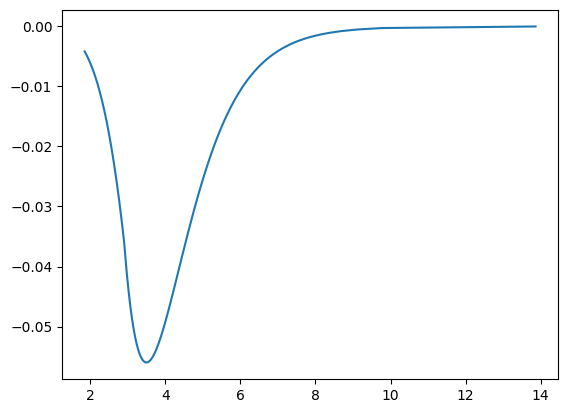

In [796]:
Ts__ =np.linspace(50, 108.999, 1000)
zs__ = Ts__/109
fz__ = lambda z: 2*np.arctan(z)-np.log(np.abs(((z-1)/(z+1))))
fZ_ = fz__(zs__)
zf1_ = lambda f: 1-5*np.exp(-f)
zf0_ = lambda f: np.where(f<2.905, f/4, zf1_(f))

# plt.plot(fZ_, zs__-fZ_/4)
# plt.plot(fZ_[1:], np.diff(zf0_(fZ_)))
plt.plot(fZ_, (zs__ - zf0_(fZ_)))
# plt.plot(zs__, (zs__ - zf0_(fZ_)))
# plt.plot(fZ_, .467*np.sqrt(np.abs(.39*fZ_-1)) +.511 - zs__)

From the same kind of assumptions we can get a similar precision with $z$ at infinity $\sqrt[3]{\dfrac{4}{3(f-\pi)}}$ (f<3.8) and close to equilibrium $1+e^{2.5-f}$.

In [743]:
f_z_p.series(z,sy.oo,5,'-')

4/(3*z**3) + pi + O(z**(-5), (z, oo))

In [744]:
sy.solve(_.removeO() - C1, z)[0]

2**(2/3)*(1/(3*C - 3*pi))**(1/3)

In [792]:
f_z_p.series(z,1,3,'+')

pi/2 + log(2) - 3/2 - log(z - 1) - 5*(z - 1)**2/8 + 3*z/2 + O((z - 1)**3, (z, 1))

In [896]:
z - 4/3*sy.root(z,5) + 1.66 - (.001-0.003*(z-6.2)**2)

-1.33333333333333*z**(1/5) + z + 0.11532*(0.161290322580645*z - 1)**2 + 1.659

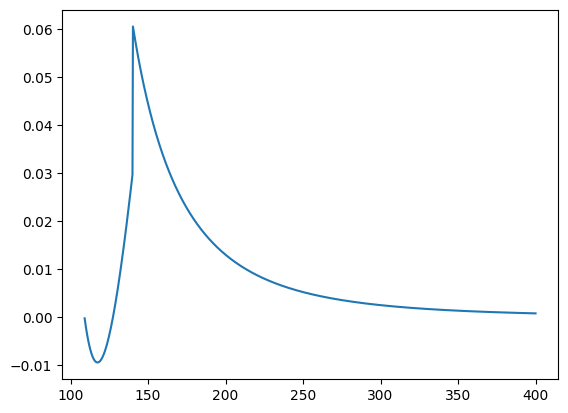

In [962]:
Ts__ =np.linspace(109.1, 400, 1000)
zs__ = Ts__/109
fz__ = lambda z: 2*np.arctan(z)-np.log(np.abs(((z-1)/(z+1))))
fZ = fz__(zs__)
zf_ = lambda f: np.where(f<3.9, (4/3/(f-np.pi))**(1/3), 1+np.exp(2.5-f))
dFinf = (4/3/(fZ-np.pi))**(1/3)
dFZ = zs__ - dFinf
dFr = - 4/3*fZ**.2 + 1.66 #- (.001-0.003*(fZ-6.2)**2)
# plt.plot(zs__, ((4/3/(fZ-np.pi))**(1/3) - dFr)-zs__ )
plt.plot(zs__*109, (zs__ - zf_(fZ))/zs__)
# plt.plot(fZ, dFinf, '--')
# plt.plot(fZ, 1+np.exp(-fZ+2.5), '-.')

Combining this together, we can easily cobble this piecewise approximation of a proper numeric integration.

In [983]:
VMOLARREF = 8.31 * 132.65 / 3771e3
SIGMA_SB = 5.6704e-8
T_CMB = 3.15
T_EQUIL = (T_CMB**4 + 200*0.04/SIGMA_SB)**(1/4)
print(T_EQUIL)
def cool_iter(T, nu, n):
    eta = min(VMOLARREF*nu/n/.07,1)
    C = nu*20
    for _ in range(n):
        dQ = 2 * eta * (200 * 0.04 - SIGMA_SB * (T**4-T_CMB**4))
        T += dQ/C
    return T
def cool_rough(T,nu,n):
    Cv_eff = max(nu, n*.07/VMOLARREF)*20
    An = 2*n/Cv_eff
    T1 = (3*SIGMA_SB*An + T**-3)**(-1/3)
    T1 += (200*0.04 - SIGMA_SB*T_CMB**4)*An
    return T1
def cool_prec(T,nu,n,dbg=False):
    Cv_eff = max(nu, n*.07/VMOLARREF)*20
    b = SIGMA_SB*2/Cv_eff
    k =  T_EQUIL
    z = T/k
    C = 2 * np.arctan(z) - np.log(np.abs((z-1)/(z+1)))
    f = C + 4*b*k**3*n
    if dbg: print(f'{z=}, {C=}, {f=}')
    if z<1:
        if f<2.905: return T_EQUIL*(f/4)
        else: return T_EQUIL*(1-5*np.exp(-f))
    else:
        if f<3.9: return T_EQUIL*(4/3/(f-np.pi))**(1/3)
        else: return T_EQUIL*(1+np.exp(2.5-f))

108.98560729819874


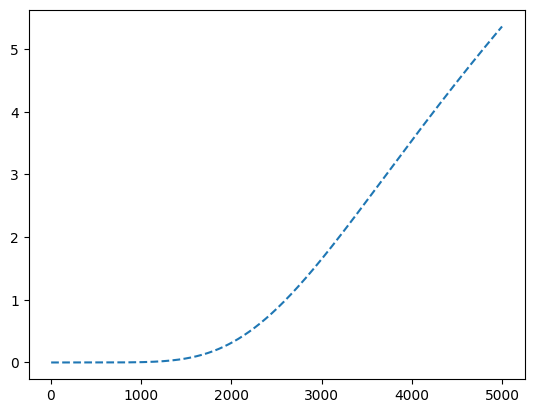

In [1014]:
n = 200
Ts = np.linspace(3, 5000, 1000)
Titer = np.array([cool_iter(T, 3400, n) for T in Ts])
Trough = [cool_rough(T, 3400, n) for T in Ts]
Tprec = [cool_prec(T, 3400, n) for T in Ts]
# plt.plot(Ts, Ts-Titer)
# plt.plot(Ts, Ts-(Trough), '--')
# plt.plot(Ts, Ts - Tprec, '-.')
plt.plot(Ts, Trough-Titer, '--')
# plt.plot(Ts, Tprec-Titer, '-.')

In [58]:
pinhom = sy.integrate(1/(b*k**4-b*y**4),y) + C #.subs({y: k*z})
sy.Eq(x, inhom)

Eq(x, C - log(-k + y)/(4*b*k**3) + log(k + y)/(4*b*k**3) + atan(y/k)/(2*b*k**3))

In [63]:
sy.solve(inhom, C)[0]

(log(-k + y) - log(k + y) - 2*atan(y/k))/(4*b*k**3)

In [65]:
_.subs({k: 67, y: 1000, b: 1.2e-13}).evalf()

-21774130.4272155

In [24]:
indef = sy.integrate(1/(-sigma*T**4), T) - C/3/sigma
indef2 = sy.solve(sy.Eq(t, indef), T)[0]
sy.Eq(T, indef2)

Eq(T, (C + 3*\sigma*t)**(-1/3))

In [25]:
sy.solve(sy.Eq(indef2.subs({t: 0}), T0), C)

[T_0**(-3)]

In [23]:
x = sy.Symbol('x', real = True, positive = True)

In [24]:
sy.solve(sy.Eq((1-x) - .15*x,0))

[0.869565217391304]

In [2]:
P, P0, tau, lamda = sy.symbols('P P_0 \\tau \\lambda', real=True, positive=True)
C = sy.Symbol('C', real=True)

In [26]:
sy.integrate(1/-(P/lamda)**3, P) - C

-C + \lambda**3/(2*P**2)

In [27]:
P_t = sy.solve(_-tau/2, P)[0]
P_t

-\lambda**(3/2)*sqrt(1/(2*C + \tau))

In [28]:
sy.solve(P_t.subs({tau: 0})+ P0, C)[0]

\lambda**3/(2*P_0**2)

In [29]:
cf = P_t.subs({C:_}).simplify()
cf

-P_0*\lambda**(3/2)/sqrt(P_0**2*\tau + \lambda**3)

In [31]:
sy.solve(P+cf, tau)[0]

-\lambda**3/P_0**2 + \lambda**3/P**2

In [32]:
700**3/100**2 - 700**3/113.776**2

7803.23844995565

In [35]:
.16*60

9.6

In [34]:
(7803/60)/60 

2.1675

In [19]:
_.subs({P0: 109.6, lamda: 700, tau: 90*60}).evalf()

-100.507632054235

In [117]:
113.76 / ((120*60) * 113.76**2/700**3 + 1 )**.5

100.87997103100399

# prev

In [2]:
x,y,b,c=sy.symbols('x y b c', real=True, positive=True)
# sy.solve(sy.integrate(1/(-b*y**4),y)-x-c,y)[
# sy.root(3*b*x+c**-3,-3).simplify()
p_e = sy.solve(sy.integrate(1/(-(y/c)**3),y)-x-b,y)[0] #t =
p_e2 = p_e.subs({b:sy.solve(p_e.subs({x:0})-y,b)[0]}).simplify()
p_e2.subs({c:sy.root(2*c**2,3)}).simplify()

c*y/sqrt(c**2 + x*y**2)

$y = y_0/\sqrt{ct + 1}$, $c=y_0^2/\lambda^3$

$y(t)=y_1$ @ $t=(y_0^2/y_1^2 - 1)/c$

In [13]:
sy.solve(y/sy.root(c*x+1,2)-b, x)[0].expand()

-1/c + y**2/(b**2*c)

In [14]:
P0/(ck*5474+1)**.5

NameError: name 'P0' is not defined

In [15]:
((P0/10)**2-1)/ck

NameError: name 'P0' is not defined

Second approx: Imply that turbines consume just 0.4m3 every time.

Ignoring pumps, that means that we have nets $V_h,V_c$, with $T_h,T_c$ and other args.

$\Delta T_h c_{v,m} \nu_h = \Delta Q_{sm} - \Delta E_{TEG}$

$\Delta T_c c_{v,m} \nu_c = (1-\eta_T)\Delta E_{TEG} - \Delta Q_{HE}$.

$\nu_1=\nu_h V_t/V_h; \nu_2=\nu_c V_t/V_c$, $V_t=0.4$ m3;

$\tilde{C} = \dfrac{C_1C_2}{C_1+C_2} = \dfrac{\nu_1\nu_2}{\nu_1+\nu_2} = V_t \dfrac{\nu_c\nu_h}{V_c\nu_h + V_h\nu_c}$

$\Delta E_{TEG} = (T_1-T_2)\tilde{C}$

$(T_h - T'_h)c_{v,m}\nu_h = k_Q\eta_rP_{sm} - (T_h-T_c)\tilde{C}$,

$(T_c-T'_c)c_{v,m}\nu_c = (1-\eta_T)(T_h-T_c)\tilde{C} - c_{v,m}\nu_c\left(
    T_d(1-\sqrt[-3]{k_1T_d^3+1})-k_2
\right)$

Stationary sol'n gets deltas = 0, i.e.,
($P_\Theta = k_Q\eta_rP_{sm}$ -- `ThP`)

$T_h - T_c = P_\Theta / \tilde{C}$,

$(1-\eta_T)(T_h-T_c)\tilde{C} = c_{v,m}\nu_c \Delta T_{rad}$

In [19]:
_vc, _vh,_vt,_nuh,_nuc =sy.symbols('V_c V_h V_t \\nu_h \\nu_c')
_nu1,_nu2 = _vt * _nuh/_vh, _vt * _nuc/_vc
((_nu1*_nu2/(_nu1+_nu2))/_nu1).simplify()

V_h*\nu_c/(V_c*\nu_h + V_h*\nu_c)

In [20]:
eta_C = 0.4 *cv* (nu_canister / (cool_V+hot_V))
nu1,nu2 = 0.4*nu_canister/hot_V, 0.4*nu_canister/cool_V
eta_C
Eer = 113
ThP = 5.5e3*Eer
ThP/eta_C, ThP/eta_C*nu1*cv*.65

(404.6613122272687, 565139.864864865)

More precise mathmodel

In [21]:
Vc1 = 13.37+1.47+0.77 + 3*.2 # this is wat is cooled/ cool turb out
Vc2 = .67 #cool turbine inp
Vh2 = 1.995 + .2 +.7 + 2 # filters / hot turb out
Vh1 = .315 + .4 + .2 # hot turb in
Vh0 = 37.5 # room

Stationary:

$\dot\nu_{c1} = \Delta\nu_{T2} - \Delta\nu_{HP1} = 0$

$\dot\nu_{c2} = \Delta\nu_{HP1} - \Delta\nu_{T2} = 0$

$\dot\nu_{h2} = \Delta\nu_{T1} - \Delta\nu_{PO1} = 0$

$\dot\nu_{h0} = \Delta\nu_{PO1} - \Delta\nu_{PI1} = 0$

$\dot\nu_{h1} = \Delta\nu_{PI1} - \Delta\nu_{T1} = 0$

This means, that $\Delta\nu_{T2} = \Delta\nu_{HP1} = \dot\nu_c$, and
$\Delta\nu_{PI1} = \Delta\nu_{PO1} = \Delta\nu_{T1} = \dot\nu_h$.

First let's assume that it's purely power rating-limited. This means, that

$\Delta\nu_{PI1} = N_{45}/N_{s,h2,h0} = \Delta\nu_{PO1} = N_{30}/N_{s,h0,h1} = \Delta\nu_{T1}$;

$\Delta\nu_{HP1} = N_{45}/N_{s,c1,c2} = \Delta\nu_{T2}$.

$N_{s,h2,h0} = 3/2 N_{s,h0,h1}$;

$T_{h0} \log\dfrac{1+c_1T_{h0}^{2/3}/p_{h0}}{1+c_1T_{h2}^{2/3}/p_{h2}} = \dfrac{3}{2} T_{h1} \log\dfrac{1+c_1T_{h1}^{2/3}/p_{h1}}{1+c_1T_{h0}^{2/3}/p_{h0}} = -\dfrac{5N_{s,h}}{2R}$

$T_{c2} \log\dfrac{1+c_1T_{c2}^{2/3}/p_{c2}}{1+c_1T_{c1}^{2/3}/p_{c1}} = - \dfrac{5N_{s,c}}{2R}$

$\dot\nu_h = \Delta\nu_{T1} = \dfrac{1}{RT_{h2}} P_{h2} V_i = N_{45}/N_{s,h}$,

$\dot\nu_c = \Delta\nu_{T2} = \dfrac{1}{RT_{c2}} P_{c2} V_i = N_{45}/N_{s,c}$,

$\dfrac{5N_{s,c}}{2R} \dfrac{P_{c2}V_i}{T_{c2}} = \dfrac{5}{2}N_{45}$,

$\dfrac{5N_{s,c}}{2R} \dfrac{P_{c2}V_i}{T_{c2}} = \dfrac{5}{2}N_{45}$,



$-{P_{c2}} \log\dfrac{1+c_1T_{c2}^{2/3}/p_{c2}}{1+c_1T_{c1}^{2/3}/p_{c1}} = \dfrac{5N_{45}}{2V_i}$

$-P_{h2} \log\dfrac{1+c_1T_{h0}^{2/3}/p_{h0}}{1+c_1T_{h2}^{2/3}/p_{h2}}  = \dfrac{5N_{45}}{2V_i} \dfrac{T_{h2}}{T_{h0}}$

As well as: $\nu_{h1}+\nu_{h2}+\nu_{h0}=3\nu_C$;
$\nu_{c1}+\nu_{c2}=3\nu_C$; $\nu_C$ -- single engine N2 canister

Now we take note of heats:

$\nu_{h1} c_v T_{h1} = (\nu_{h1} - \dot\nu_h) c_v T_{h1} + \dot\nu_h c_v T_{h0}$
=> $T_{h1} = T_{h0} = T_h$

$\nu_{h2} c_v T_{h2} = (\nu_{h2} - \dot\nu_h) c_v T_{h2} + \dot\nu_h c_v T_{h1} - \Delta E_{TEG}$ => $\dot\nu_h c_v T_{h2} = \dot\nu_h c_v T_{h1} - \Delta E_{TEG}$

=> $T_{h2} = T_w = T_h - \dfrac{\Delta E_{TEG}}{\dot\nu_h c_v}$

$\nu_{h0} c_v T_{h0} = (\nu_{h0} - \dot\nu_h) c_v T_{h0} + \dot\nu_h c_v T_{h2} + \Delta Q_{SM}$ => $\dot\nu_h c_v T_{h0} = \dot\nu_h c_v T_{h2} + \Delta Q_{SM}$

=> $\Delta E_{TEG} = \Delta Q_{SM}$

$\Delta E_{TEG} = (T_{h01} - T_{c2}) c_v \dfrac{\dot\nu_h \dot\nu_c}{\dot\nu_h+\dot\nu_c} = N_\Theta$ ($N_\Theta$ -- `ThP`)

$\nu_{c1} c_v T_{c1} = (\nu_{c1} - \dot\nu_c) c_v T_{c1} + \dot\nu_c c_v T_{c2} + (1-\eta_T)\Delta E_{TEG} - \Delta Q_{HE}$

$\nu_{c2} c_v T_{c2} = (\nu_{c2} -\dot\nu_c) c_V T_{c2} + \dot\nu_c c_v T_{c1}$ => $T_{c2}=T_{c1}$

$(1-\eta_T)\Delta E_{TEG} = \Delta Q_{HE} = c_v \nu_c \Delta T_{rad} = c_v \nu_{c1} \left(
    T_d(1 - \dfrac{1}{\sqrt[3]{k_1T_d^3+1}})-k_2
 \right)$

$\Delta T_{Eq} = (1-\eta_T) \Delta E_{TEG} / c_v / \nu_{c1}$

$\Delta E_{TEG} = (T_h - T_c) \tilde{C} = N_\Theta$

$\dot\nu_h = \dfrac{P_{h2} V_i}{RT_w}$,
$\dot\nu_c = \dfrac{P_{c2} V_i}{RT_c}$,

$\tilde{C} = c_v (\dot\nu_h^{-1} + \dot\nu_c^{-1})^{-1} =
\dfrac{c_v V_i}{R}(\dfrac{T_w}{P_{h2}}+\dfrac{T_c}{P_{c2}})^{-1} =
\dfrac{c_v V_i}{R}\dfrac{P_{c2}P_{h2}}{T_wP_{c2}+T_cP_{h2}}$


$-{P_{c2}} \log\dfrac{1+c_1T_c^{2/3}/p_{c2}}{1+c_1T_c^{2/3}/p_{c1}} = \dfrac{5N_{45}}{2V_i}$

$-P_{h2} \dfrac{T_h}{T_w} \log\dfrac{1+c_1T_h^{2/3}/p_{h0}}{1+c_1T_w^{2/3}/p_{h2}}  = \dfrac{5N_{45}}{2V_i}$

In [22]:
Ph1,Ph2,Ph0,Pc1,Pc2 = sy.symbols('P_{h1} P_{h2} P_{h0} P_{c1} P_{c2}', real=True, positive=True)
Th,Tc,Tw = sy.symbols('T_h T_c T_w', real=True, positive=True)
PTh = sy.symbols('N_\Theta', real=True, positive=True)

In [23]:
_cv, _vi, _Vc1, _R, _c1, _c2, _eta, _k1, _k2, _nuc = sy.symbols('c_v V_i V_{c1} R c_1 c_2 \\eta_T k_1 k_2 \\nu_c')
cv = 20
vi = 0.4
R = 8.314
mu = .028
c_1 = R*(mu*cv)**(2/3.)
c_2 = 45000 * 5 /2/vi
eta=.65

In [574]:
nu_c1 = Pc1*Vc1/_R/Tc # pV = nu RT
seq1 = sy.Eq((1-_eta)*PTh, _cv*nu_c1*Tc*(1-sy.root(_k1*Tc+1,-3)))
# unkn: Pc1, Tc
# - neu -
dnh = Ph2*_vi/_R/Tw
seqTh = sy.Eq(Th, Tw + PTh/dnh/_cv)
# -
tilde_C = _cv*_vi/_R * (Pc2*Ph2)/(Tw*Pc2+Tc*Ph2)
seq2=sy.Eq(Th, PTh/tilde_C - Tc) # D E TEG / D Q SM
#unkn: Pc2,Ph2,Tc,Th,Tw + {Pc1 up}
seq3=sy.Eq(
    (1+_c1*sy.root(sy.Pow(Th, 2),3)/Ph0),
    sy.exp(-_c2*Tw/(Ph2*Th)) * (1+_c1*sy.root(sy.Pow(Tw, 2),3)/Ph2)
)
#unkn: Ph2,Th,Ph0,Tw + {Pc1, Pc2, Tc up}
seq4=sy.Eq(
    (1+_c1*sy.root(sy.Pow(Tc, 2),3)/Pc2),
     sy.exp( -_c2/Pc2) * (1+_c1*sy.root(sy.Pow(Tc, 2),3)/Pc1)
)
#unkn: Pc2,Tc,Pc1 + {Ph2, Th,Ph0,Tw up}
seq5 = sy.Eq(
    (1+_c1*sy.root(sy.Pow(Th, 2),3)/Ph0)**5, 
    (1+_c1*sy.root(sy.Pow(Th, 2),3)/Ph1)**3 * (1+_c1*sy.root(sy.Pow(Tw, 2),3)/Ph2)**2 
)

sPh2 = sy.Eq((Ph1*Vh1 + Ph0*Vh0)/_R/Th + Ph2*Vh2/_R/Tw, 3*_nuc )
# sy.solve(sPh2, Ph2)[0]
sPc1 = sy.Eq(nu_c1 + Pc2*Vc2/_R/Tc, 3*_nuc)

#unkn: Pc2,Tc,Pc1 + {Ph2, Th,Ph0,Tw up}

In [583]:
from IPython.display import display_latex
sysv = []
for qq in [seqTh,seq2,seq1,seq3,seq4,seq5,sPh2,sPc1]:
    display_latex(qq)
    sysv.append(qq.subs({
       _cv:20, _vi:.4, _Vc1:Vc1,
        _R:8.314, _c1:c_1, _c2:c_2, _eta:.65, _k1:k1,
        _nuc:nu_canister,
        PTh: 20*5.5e3
    }))

In [584]:
_Pc1 = sy.solve(sysv[-1],Pc1)[0]
_Ph2 = sy.solve(sysv[-2],Ph2)[0]

In [585]:
sysv2 = [k.subs({Pc1:_Pc1, Ph2:_Ph2}) for k in sysv[:-2]]

In [586]:
_Pc2 = sy.solve(sysv2[1],Pc2)[0]
_Th = sy.solve(sysv2[0], Th)[0]
sysv3 = [k.subs({Pc2:_Pc2,Th:_Th}) for k in sysv2[2:]]
# unkn: Ph0, Ph2, Tc, Tw

In [587]:
dxS = lambda x0,x1,x2,x3: [(k.lhs.subs({Ph0:x0,Ph1:x1,Tc:x2,Tw:x3}) - k.rhs.subs({Ph0:x0,Ph1:x1,Tc:x2,Tw:x3})).evalf() for k in sysv3]

In [588]:
dxS(1e5,1e5,300,300)

[38498.8496297248,
 -2.90773269671637e+22,
 0.997132812370702,
 0.00487219660113111]

In [589]:
import scipy.optimize

In [590]:
scipy.optimize.root(lambda x:[float(abs(v)) for v in dxS(*x)],[1e5,1e5,300,300])

 message: The iteration is not making good progress, as measured by the 
            improvement from the last ten iterations.
 success: False
  status: 5
     fun: [ 5.734e-06  1.018e-01  8.811e-01  1.176e-04]
       x: [ 4.262e+05 -1.426e+06 -5.487e+04  1.785e+00]
  method: hybr
    nfev: 181
    fjac: [[-9.701e-04  1.000e+00  4.220e-08  2.013e-03]
           [-1.629e-01 -2.145e-03 -7.010e-05  9.866e-01]
           [-9.866e-01 -6.292e-04  1.130e-05 -1.629e-01]
           [-2.705e-07 -1.854e-07  1.000e+00  7.101e-05]]
       r: [-2.830e-07 -6.906e-09 -1.362e-03  2.027e-03 -6.130e-12
           -2.287e-01 -6.058e-05 -1.386e+00  7.997e-06 -3.252e-06]
     qtf: [ 1.018e-01 -2.369e-04 -5.212e-04  8.811e-01]

In [507]:
x_0 = [30e5,80e5,3000,4000]

In [511]:
for i in range(20):
    dx_0 = np.array([float(x) for x in dxS(*x_0)])
    # print(dx_0)
    A = np.zeros((4,4))
    for i in range(4):
        x_1 = x_0
        x_1[i] *= 1.001
        dx_1 = (np.array([float(x) for x in dxS(*x_1)]) - dx_0)/float(x_1[i]*.001)
        A[i,:]=dx_1
    ddx = np.linalg.solve(A.T, dx_0)
    # print(ddx)
    x_1 = x_0 - ddx*0.05
    # print(x_1)
    x_0=x_1
    print(dxS(*x_1))

[-2668.73295617106, 0.00371533284481484, -2.46206033671648e-7, 0.00153258096160691]
[-2759.83388235583, 0.00341623420958959, -2.45339380255949e-7, 0.00153345211377953]
[-2844.08525479498, 0.00314360417921489, -2.44390034875863e-7, 0.00152915383197660]
[-2921.74426857850, 0.00289601405957085, -2.43357706986025e-7, 0.00140479889066447]
[-2993.06132135397, 0.00278663457676176, -2.42242392589631e-7, 0.00268303623758104]
[-3058.27694926511, 0.00259814727924579, -2.41044278537217e-7, 0.00277885652167786]
[-3117.62545743150, 0.00241867011646513, -2.39763825682360e-7, 0.00278320683651412]
[-3171.33382490280, 0.00225454757656696, -2.38401723251513e-7, 0.00278406402385167]
[-3219.62384552890, 0.00210474193663690, -2.36958938137910e-7, 0.00278425687372996]
[-3262.71347183321, 0.00196806000011784, -2.35436735995798e-7, 0.00278421507309545]
[-3300.81264291224, 0.00184337115991295, -2.33836544016874e-7, 0.00278404705765767]
[-3334.12878553118, 0.00172963181033514, -2.32160094926215e-7, 0.00278379088

In [513]:
x_0

array([1.20261325e+06, 5.01114399e+08, 4.73723977e+03, 1.28536538e+03])

In [219]:
dTeq = ThP*(1-.65) / cv / nu_canister

In [220]:
[el.subs({c:dTeq,b:k1}).evalf() for el in sy.solve(x*(1-sy.root((b*x**3+1),-3))-c,x)]

[0.484292902306527 - 572.08038658823*I,
 0.484292902306528 + 572.08038658823*I,
 0.484292902305594 + 0.279606637513811*I,
 0.484292902307461 - 0.279606637513811*I,
 -571.596776979974 - 6.12452084887657e-15*I,
 572.565362784587 + 6.12452084887657e-15*I]